# Short tau exercise: Part 2

Learning objectives:
* the reconstruction of hadronic tau decays in different decay modes (in part 1)
* __discrimination of hadronic tau decys against jets, electrons, and muons.__ (this part 2)

Additional material:
* TAU-16-003: Latest paper about tau reconstruction http://cms-results.web.cern.ch/cms-results/public-results/publications/TAU-16-003/index.html
* __DeepTau: Algorithm based on neural networks to discriminate taus against jets, muons, and electrons https://cds.cern.ch/record/2694158__

In [15]:
from __future__ import print_function # retain python 2 compatibility
import math
import ROOT
import numpy as np
from roc_tools import hists_to_roc, make_roc_plot

The following two files contain reconstructed hadronic taus. The first (ztt) contains true hadronic tau decays in a Z->tau tau sample, whereas the second file (qcd) contains reconstructed hadronic taus from QCD multijet events.

* The files were preprocessed using the tau validation tools here https://github.com/cms-tau-pog/TauReleaseValidation

We extract the two TTrees that contain one entry per tau. You can check the content of the files by browsing them with a ROOT TBrowser.

In [2]:
base_dir = '/eos/user/c/cmsdas/short-exercises/tau/'
base_dir = '/Users/jan/cernbox/public/TauExercise/'
tau_sample = f'{base_dir}/ztt_10_6_14.root'
jet_sample = f'{base_dir}/qcd_10_6_14.root'
tau_file = ROOT.TFile.Open(tau_sample)
tau_tree = tau_file.Get('per_tau')
jet_file = ROOT.TFile.Open(jet_sample)
jet_tree = jet_file.Get('per_tau')

# # The trees can be investigated in this Jupyter notebook:
# print([g.GetName() for g in jet_tree.GetListOfBranches()])
# cv = ROOT.TCanvas()
# tau_tree.Draw('tau_pt')
# cv.Draw()
# tau_tree.Draw('tau_pt', 'tau_pt > 0.') # only draw if tau was actually reconstructed
# cv.Draw()

# # Alternatively, to inspect the file, type t = ROOT.TBrowser() in an interactive ROOT 
# # session or "rootbrowse <filename>" in a shell

In the following, we define a base selection that we want all reconstructed taus to pass. We generally want to distinguish true reconstructed taus that pass some kinematic criteria from those coming from jets or leptons.
Here, we require the taus to pass decay mode finding, to have minimum recommended pT and maximum absolute value of eta, and to not be reconstructed in the two decay modes with missing charged hadrons, 5 and 6, since they are less well commissioned than the other decay modes and since the charge assignment has a larger uncertainty. However, feel free to change the selection criteria and check how the results below change, e.g. if you're interested in high pT taus or in the additional decay modes,

In [3]:
base_selection = 'tau_decayModeFindingNewDMs && tau_pt>20. && abs(tau_eta)<2.3'
base_selection += '&& tau_dm != 5 && tau_dm != 6'

To distinguish taus and jets, different observables are helpful. Classically the most important ones are so-called isolation variables that look at the sum of the pT values of all particles in a cone around the tau axis that are not used in the tau reconstruction: Since jets have high multiplicity, the isolation values tend to be high for jets while they are small for true taus, where ideally all tau energy was used in the reconstruction of the tau candidate and the only remaining particles in a cone around the tau come from pileup or the underlying event. The simplest is the sum of the pT of all charged particles that are compatible with coming from the primary interaction vertex.

In [5]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false
}

<IPython.core.display.Javascript object>

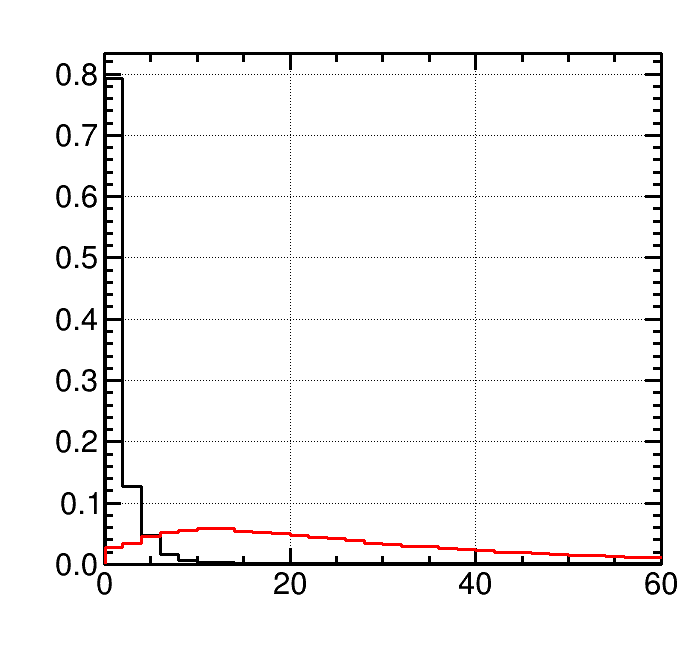

In [19]:
cv = ROOT.TCanvas()
h_ch_s = ROOT.TH1F('h_ch_s', '', 30, 0., 60.)
tau_tree.Project('h_ch_s', 'tau_chargedIsoPtSum', base_selection)
h_ch_b = ROOT.TH1F('h_ch_b', '', 30, 0., 60.)
jet_tree.Project('h_ch_b', 'tau_chargedIsoPtSum', base_selection)
h_ch_s.DrawNormalized()
h_ch_s.GetXaxis().SetTitle('charged isolation p_{T} sum [GeV]')
h_ch_b.SetLineColor(2)
h_ch_b.DrawNormalized("same")
cv.Draw()

There is apparently good separation between true taus (black curve) and jets (red curve).

*Can you find more variables that discrimate between taus and jets?*

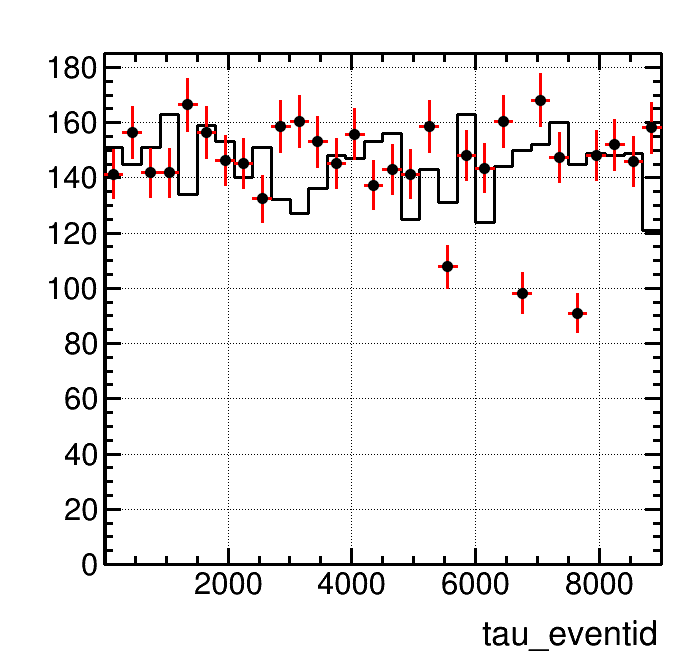

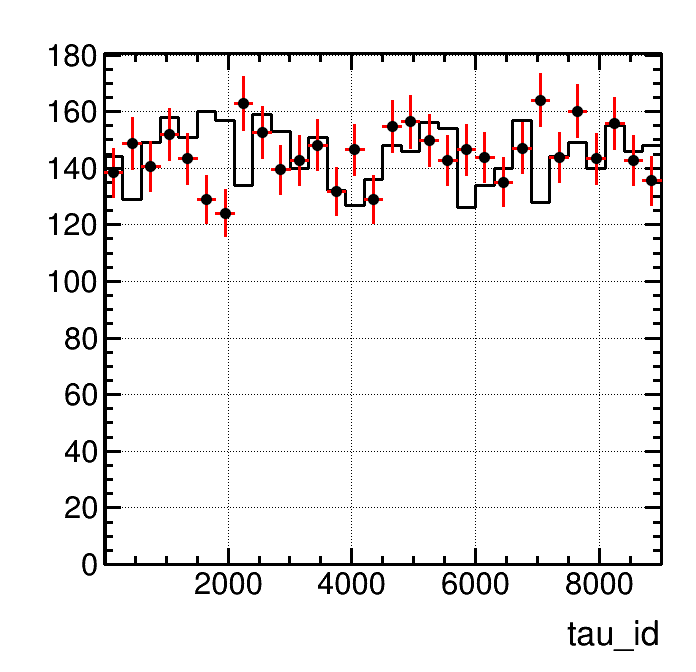

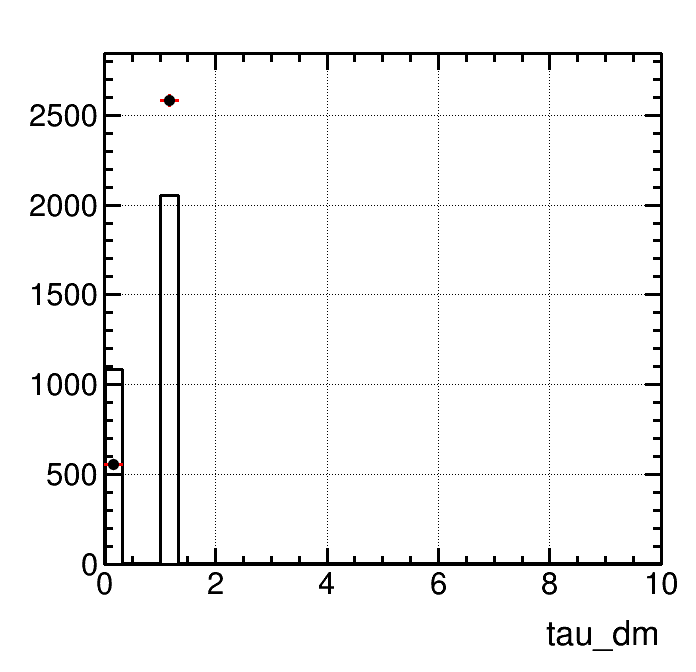

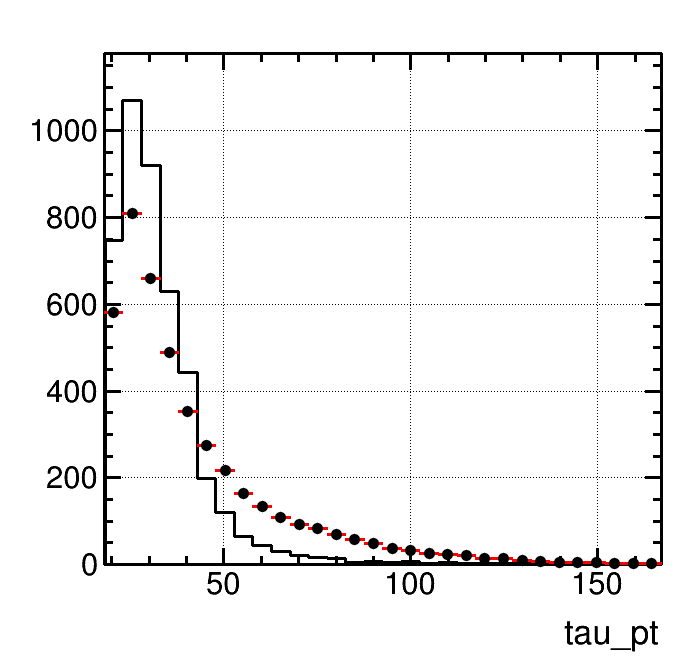

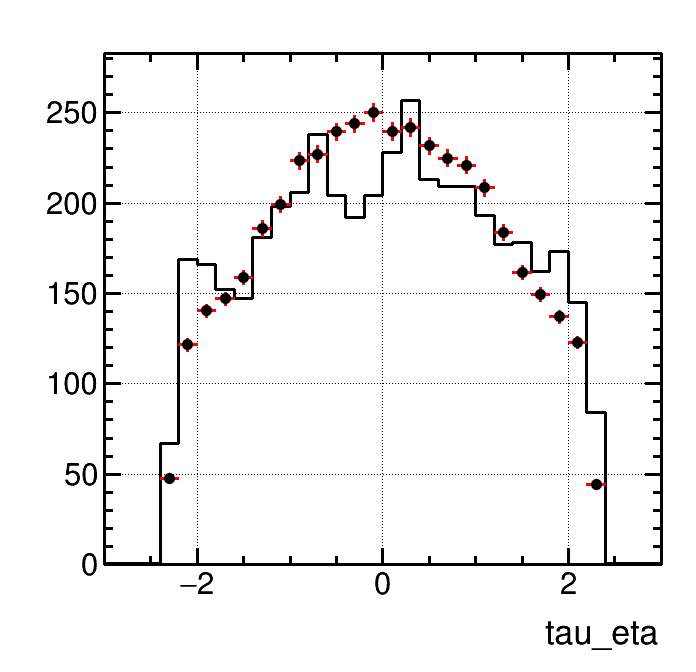

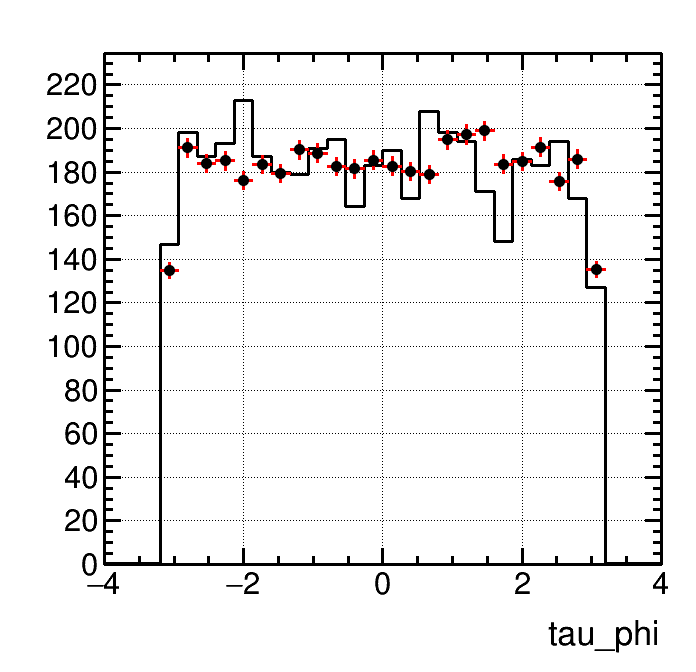

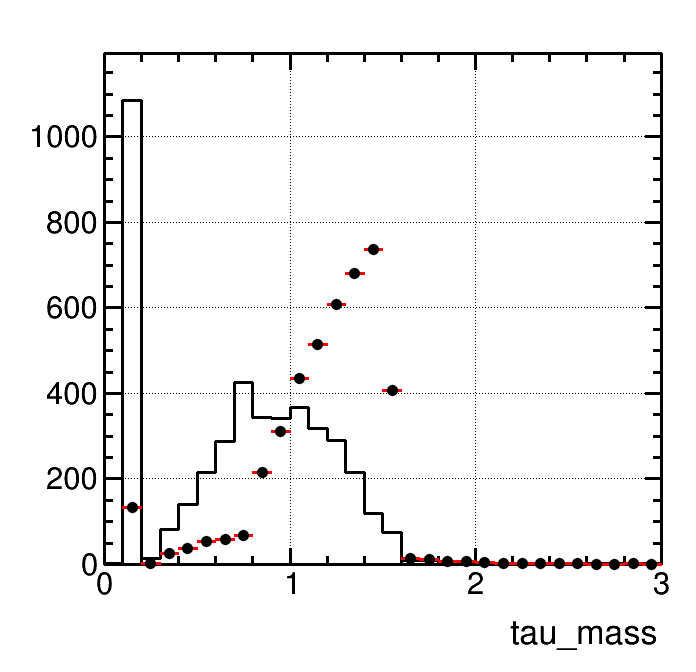

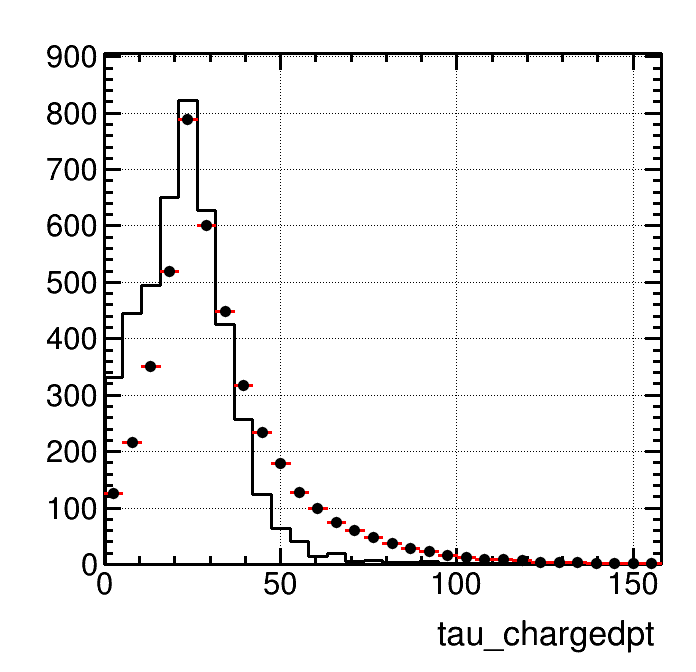

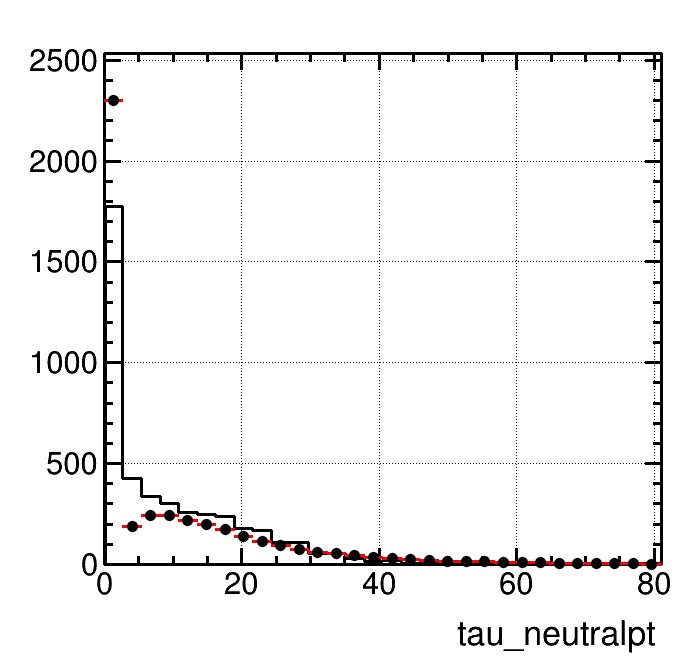

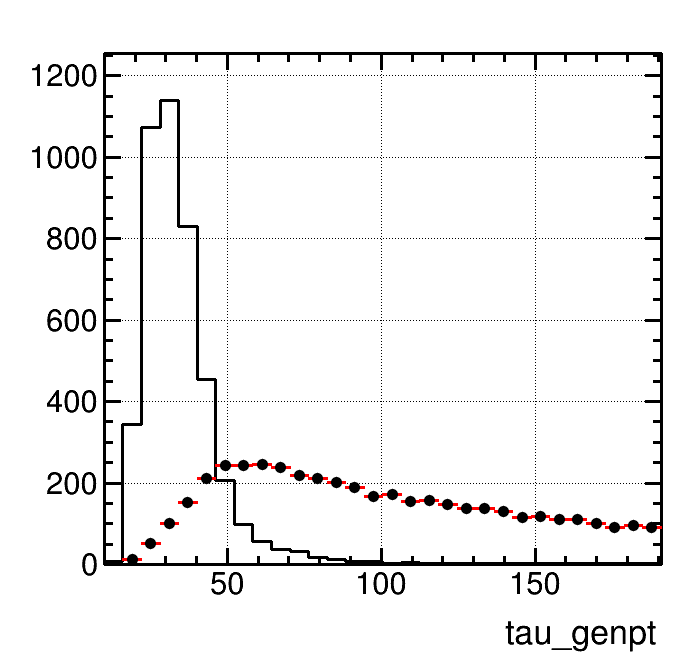

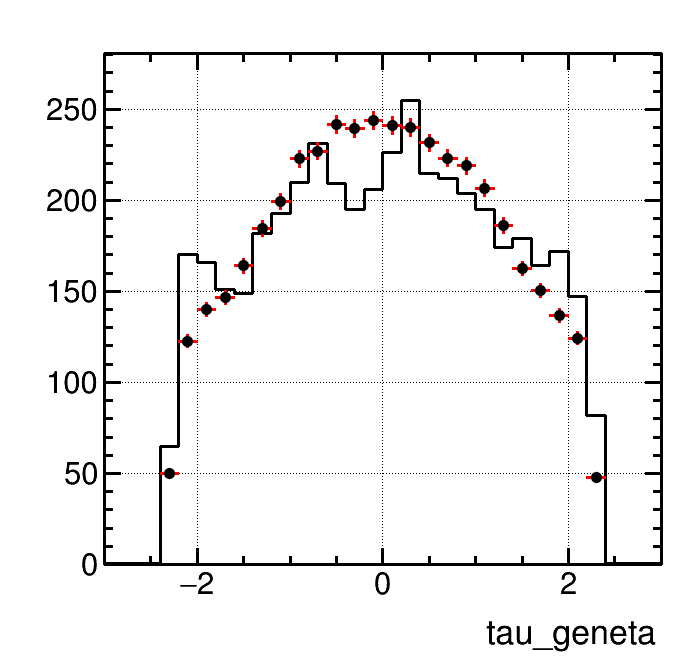

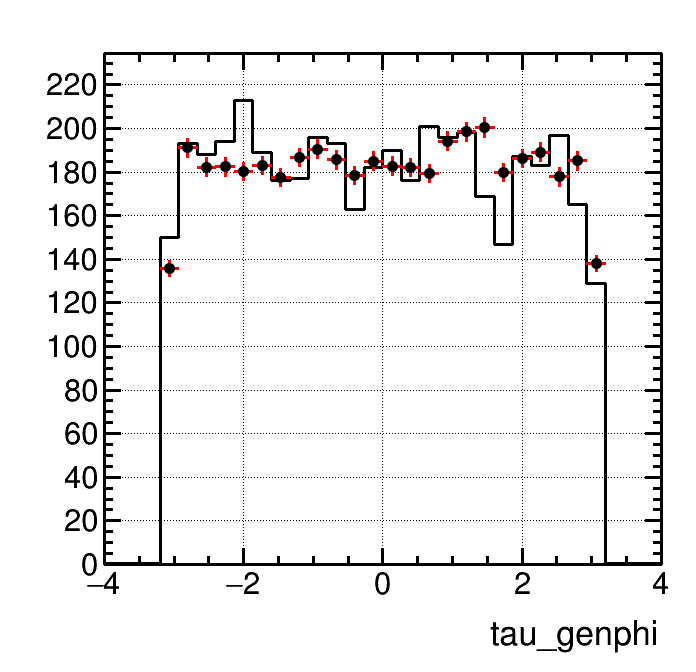

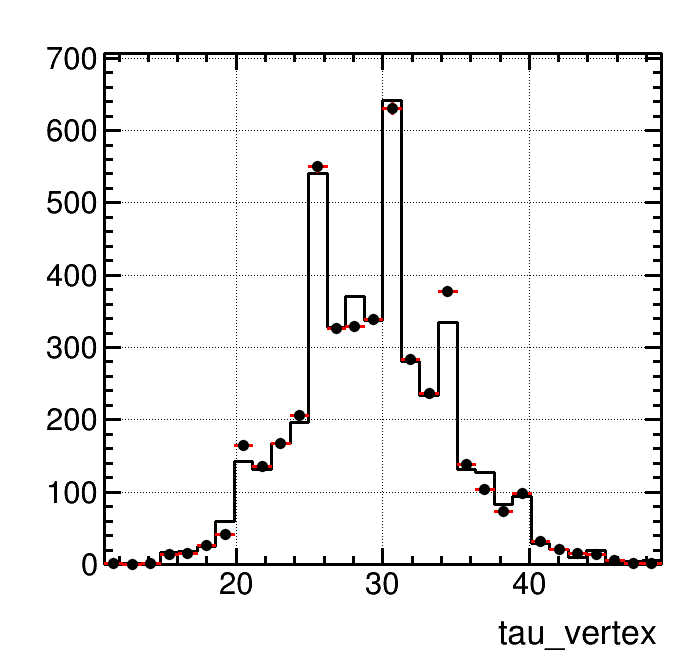

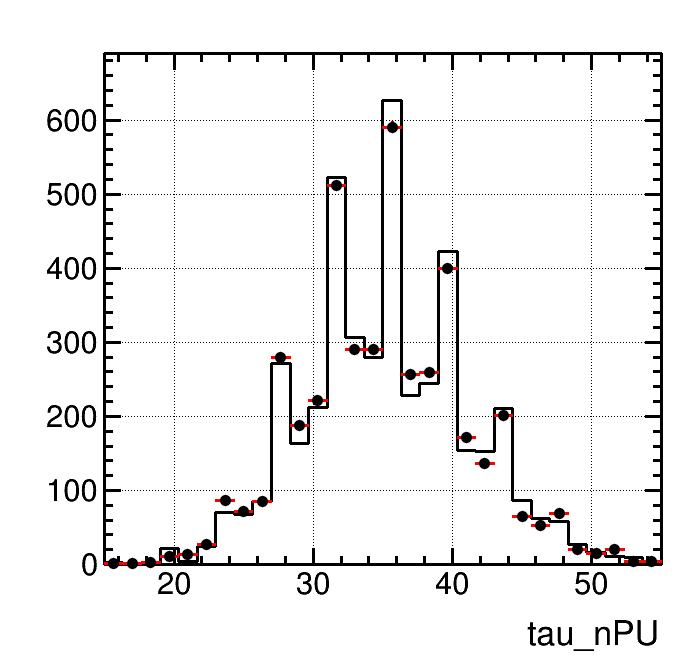

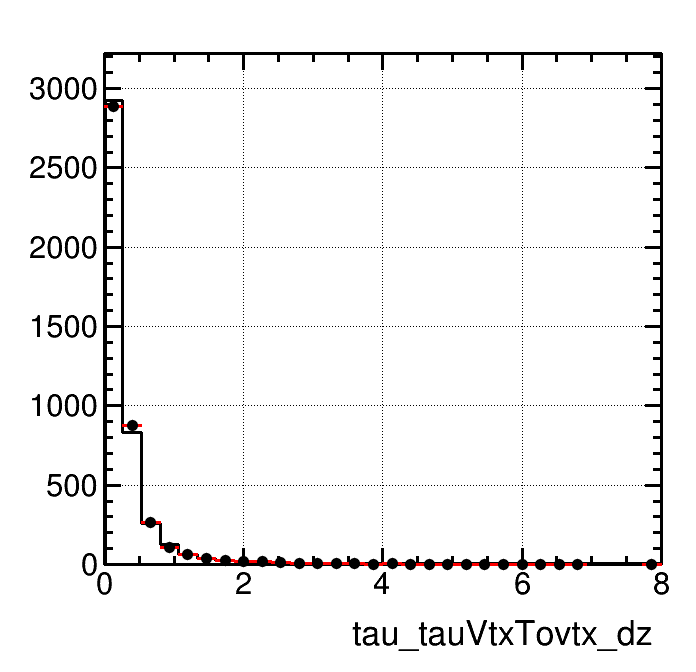

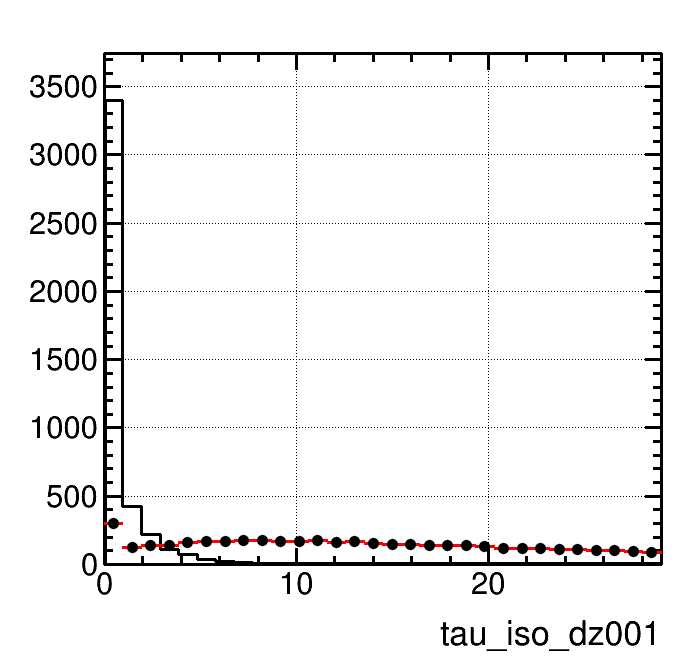

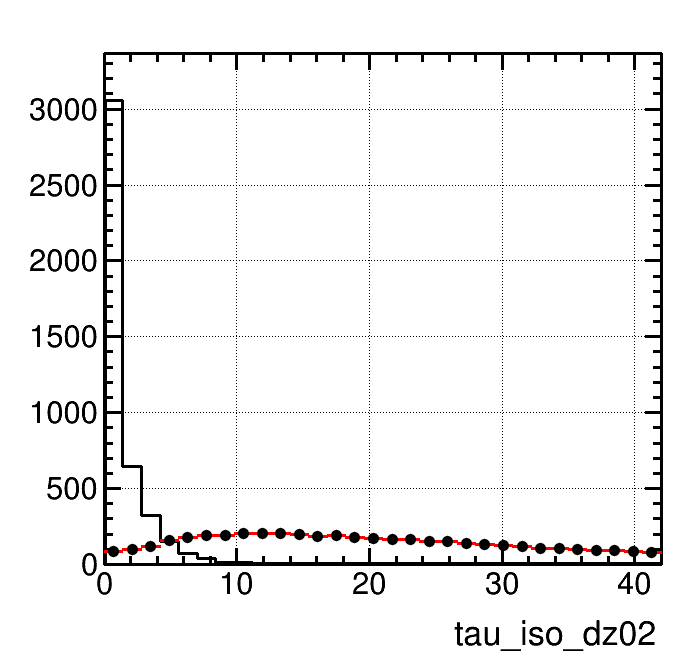

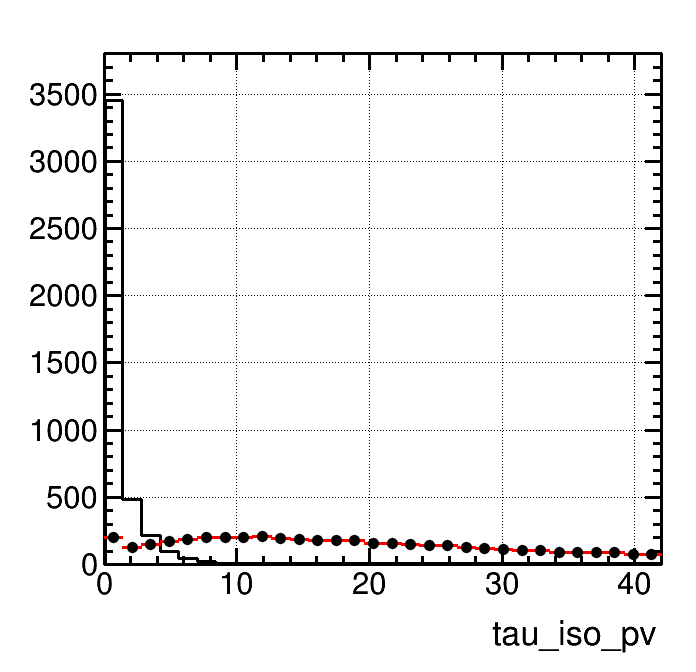

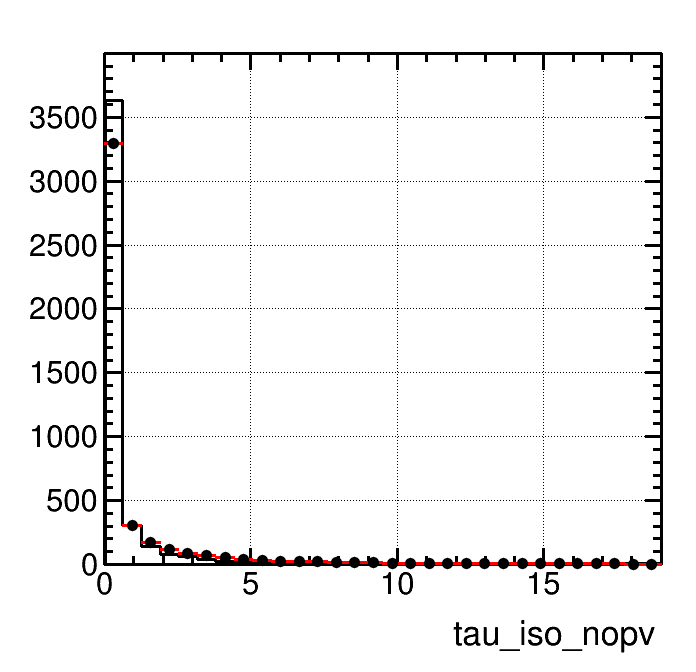

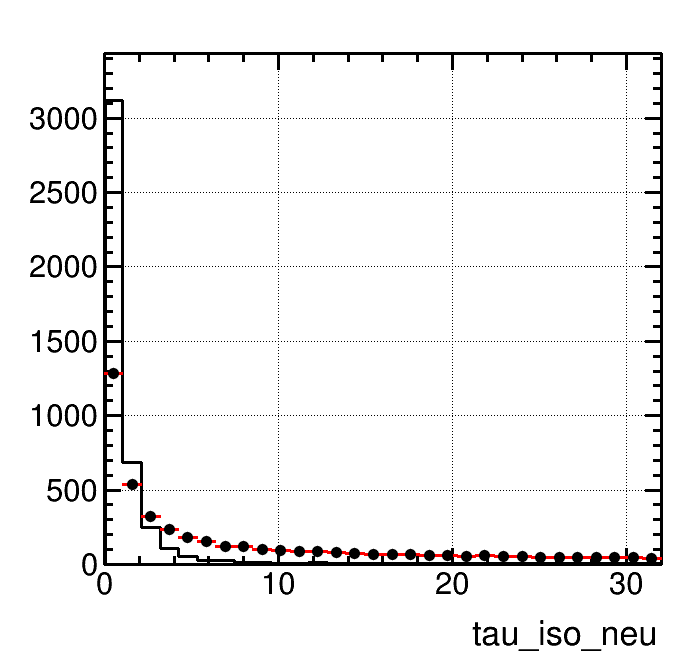

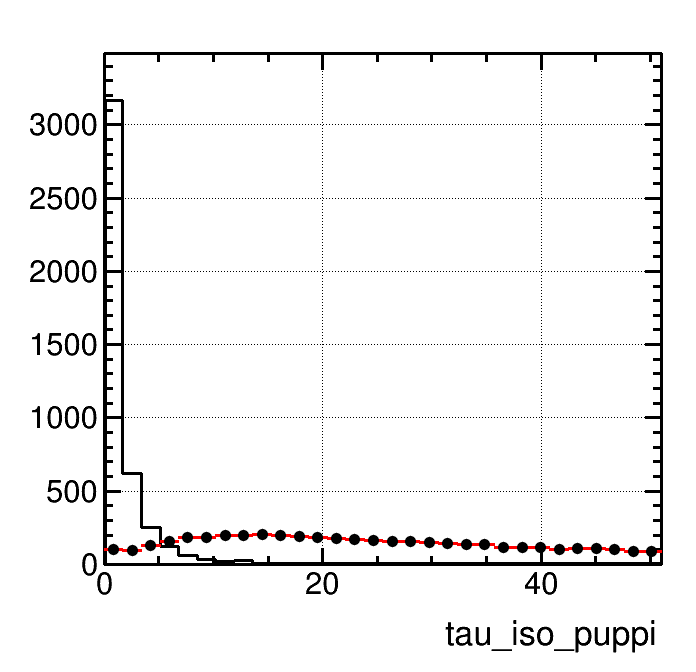

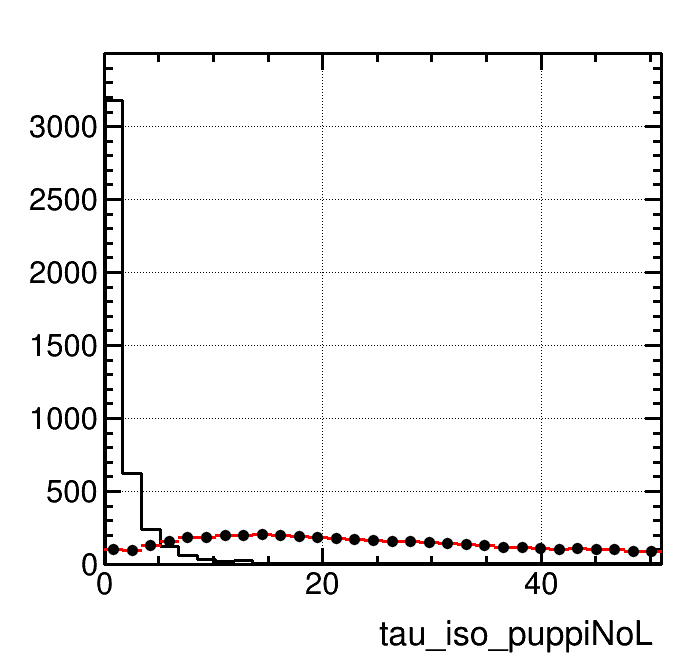

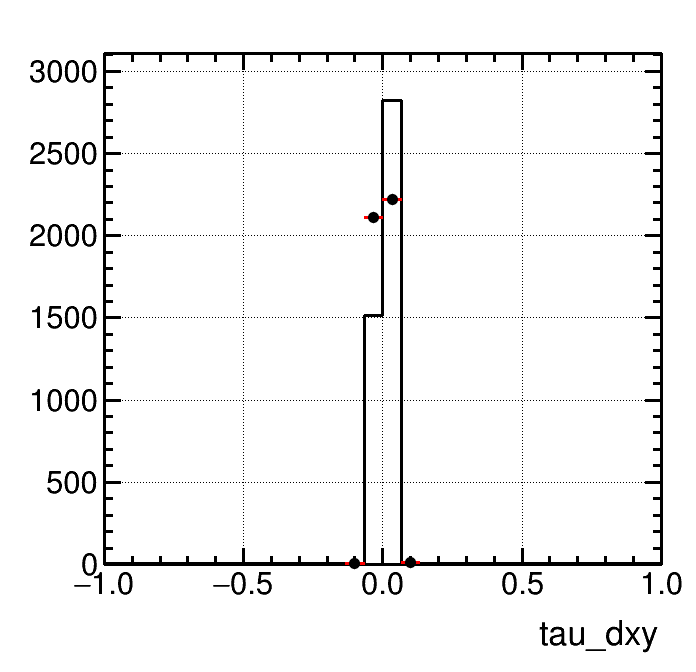

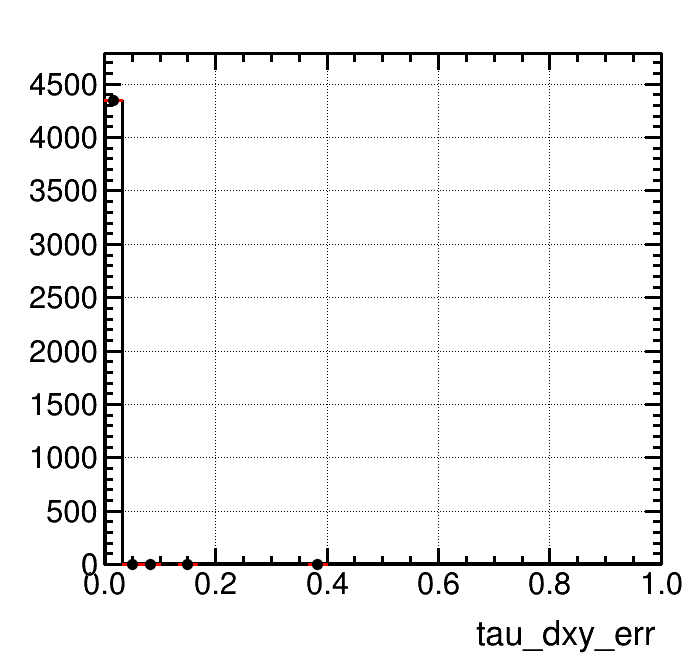

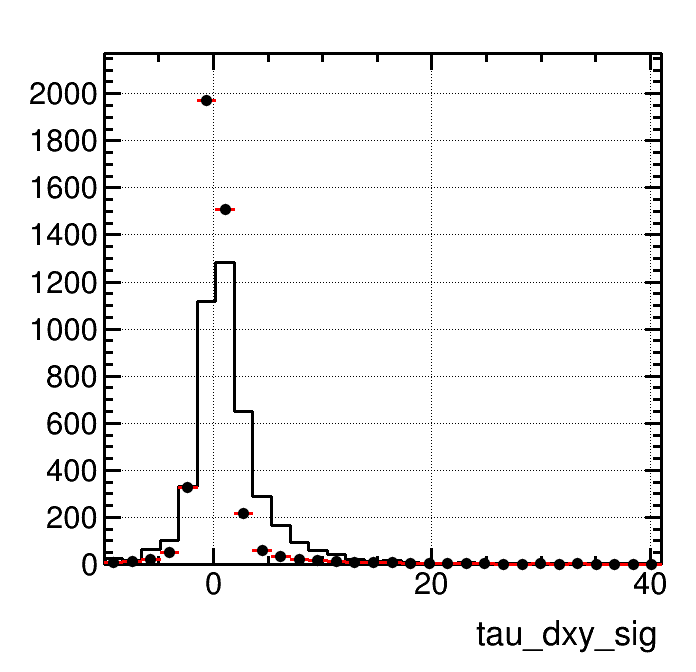

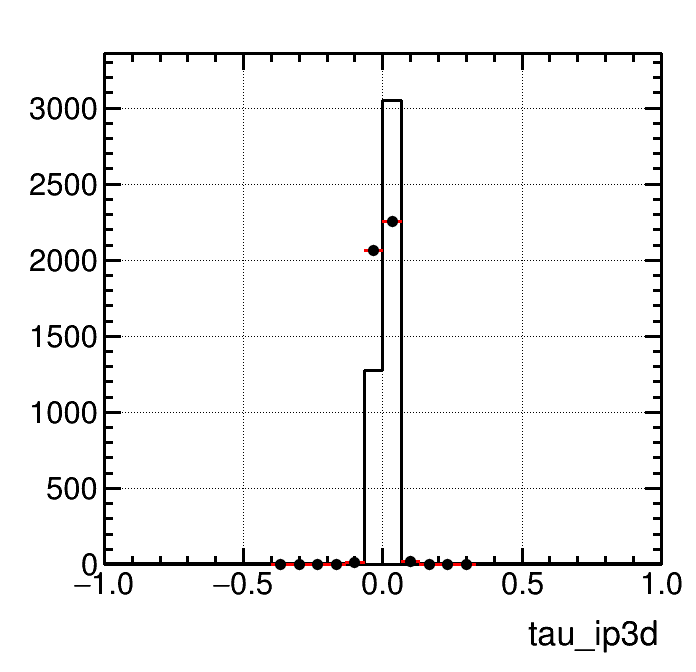

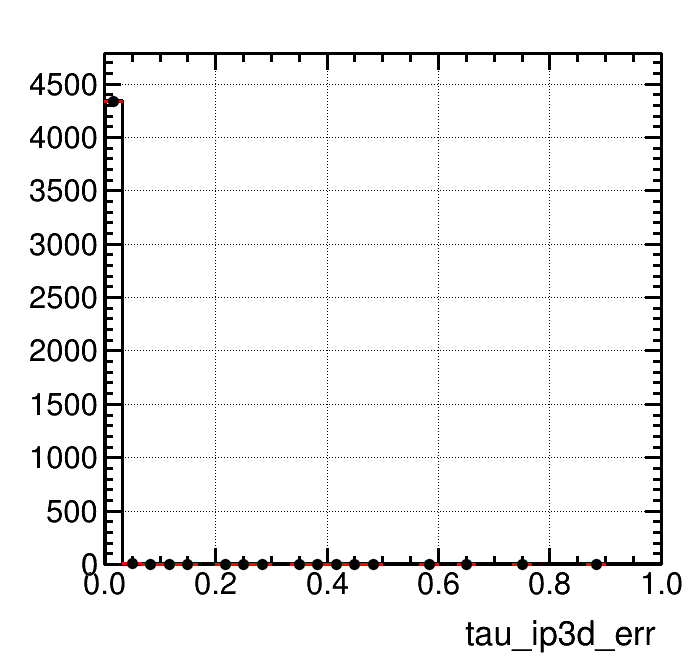

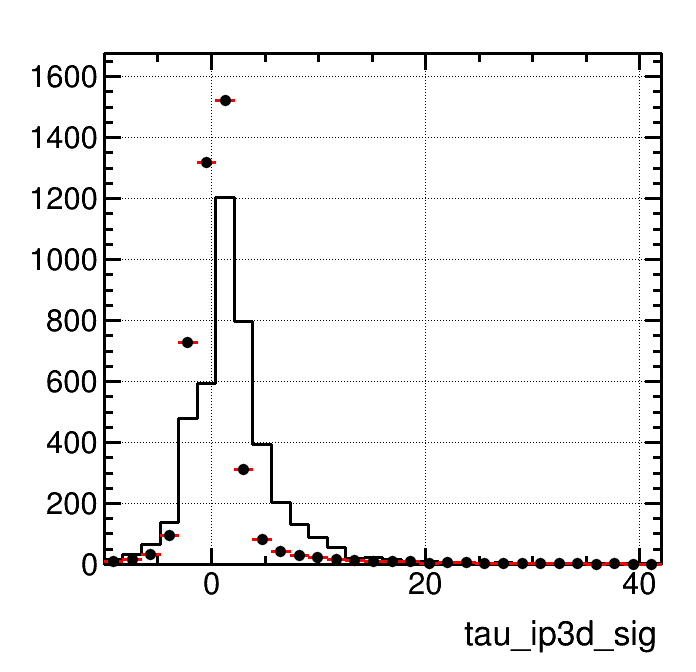

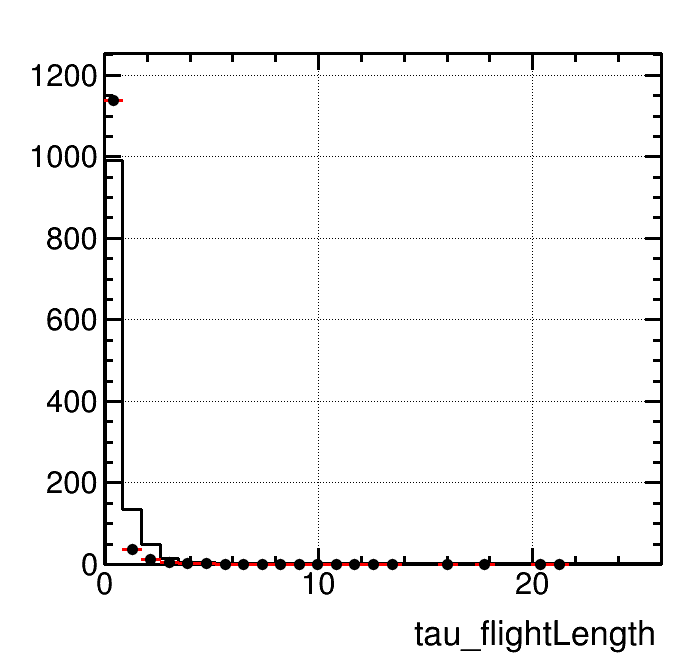

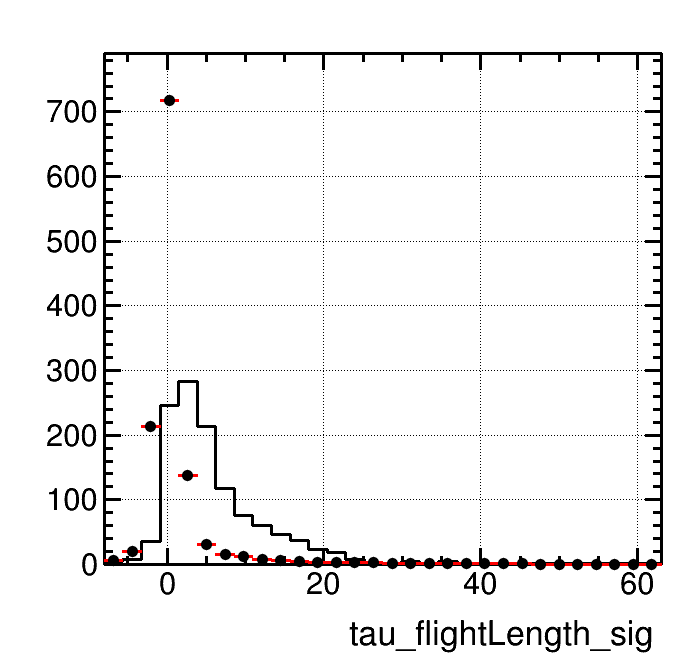

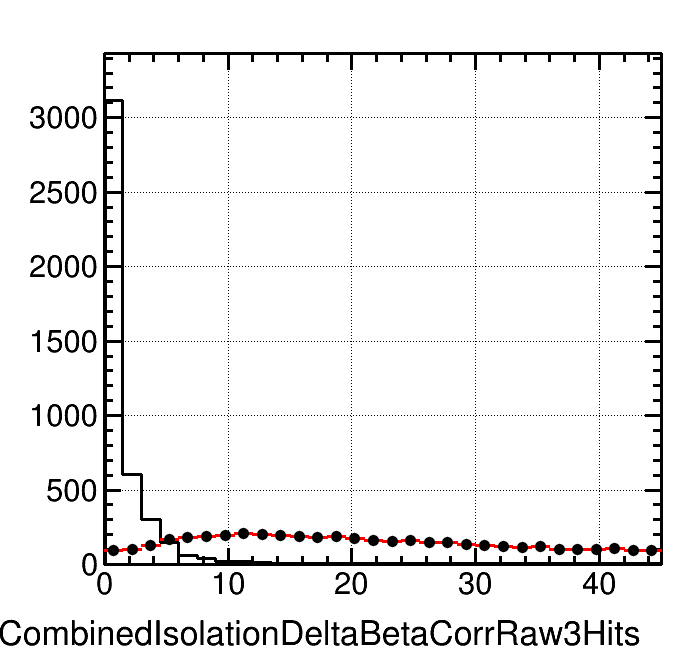

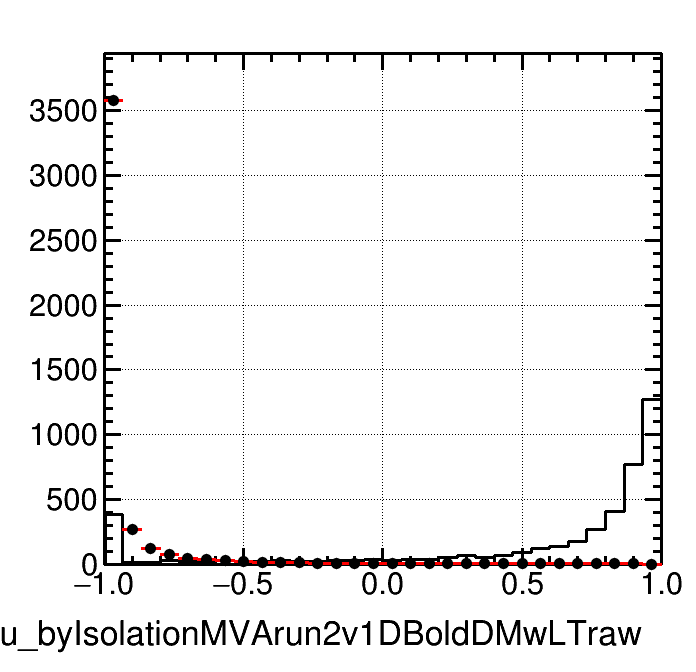

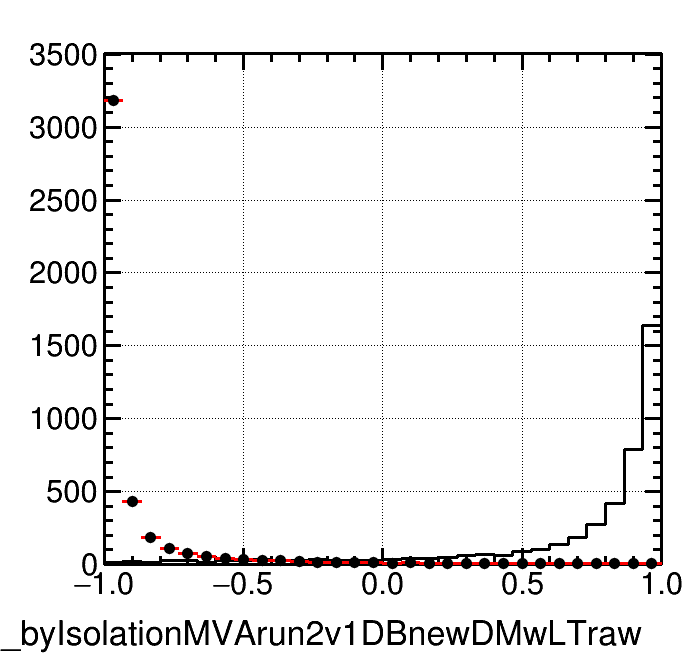

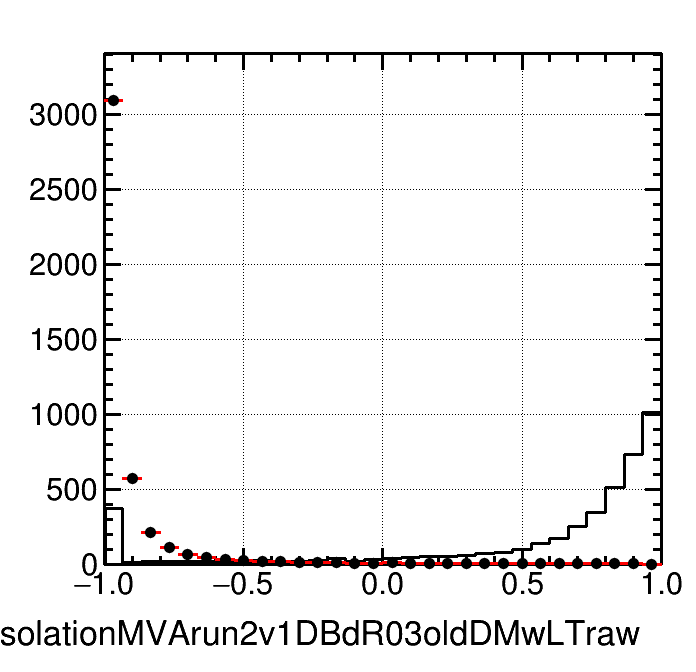

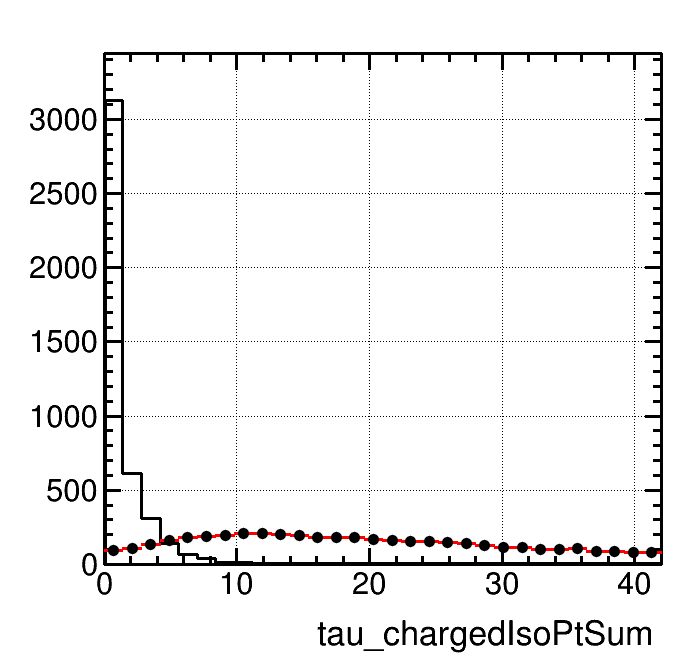

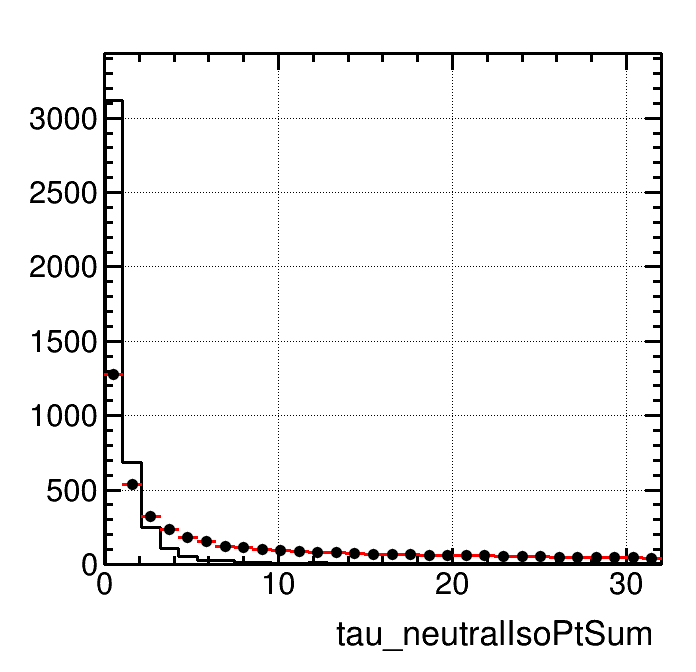

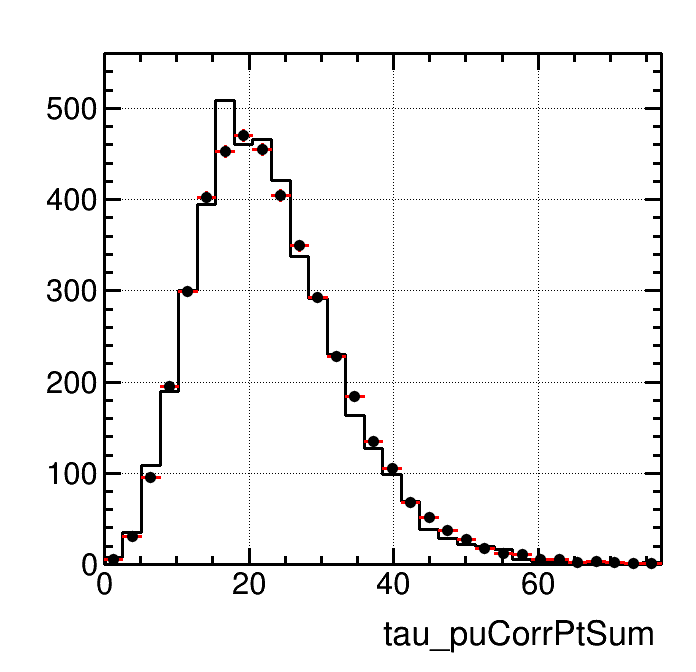

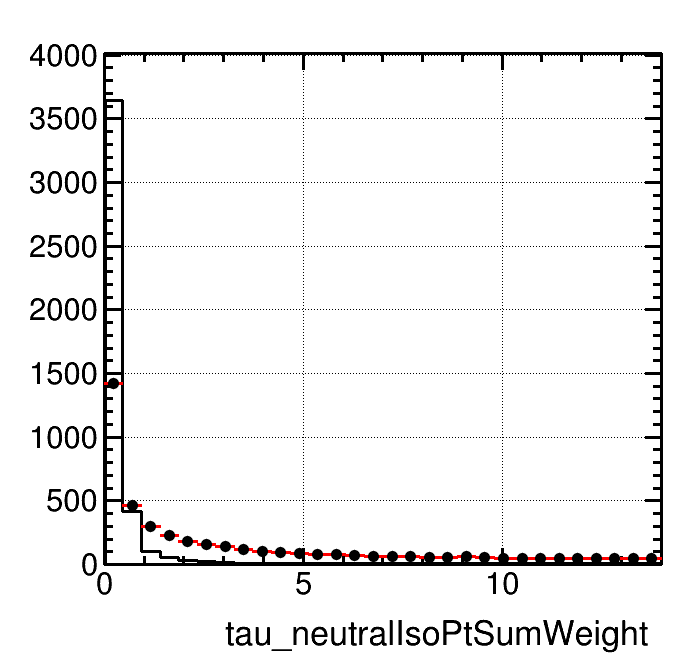

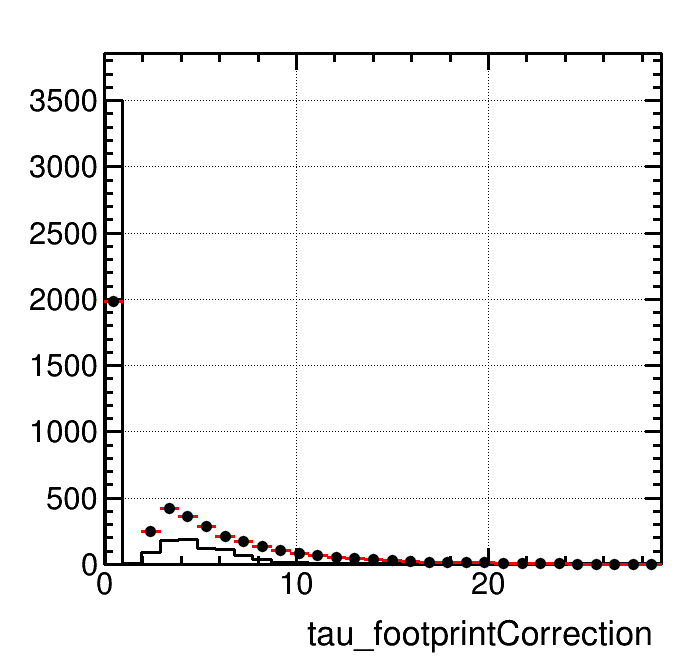

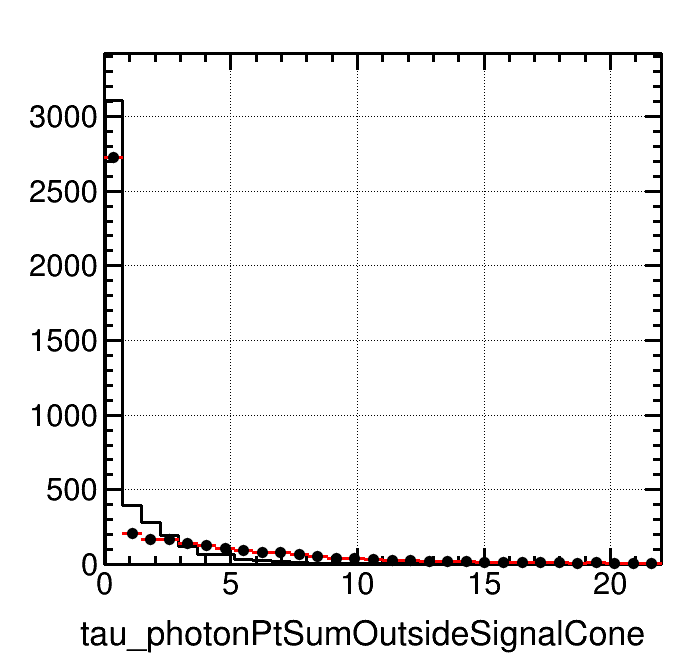

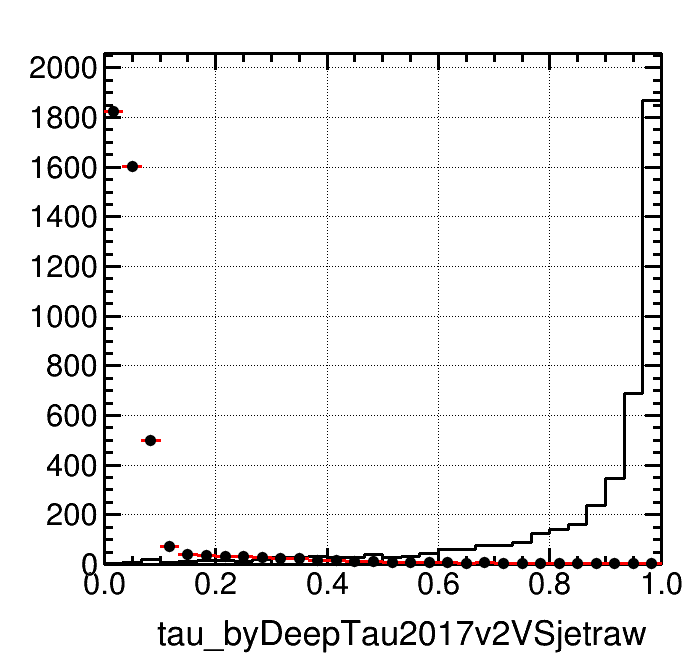

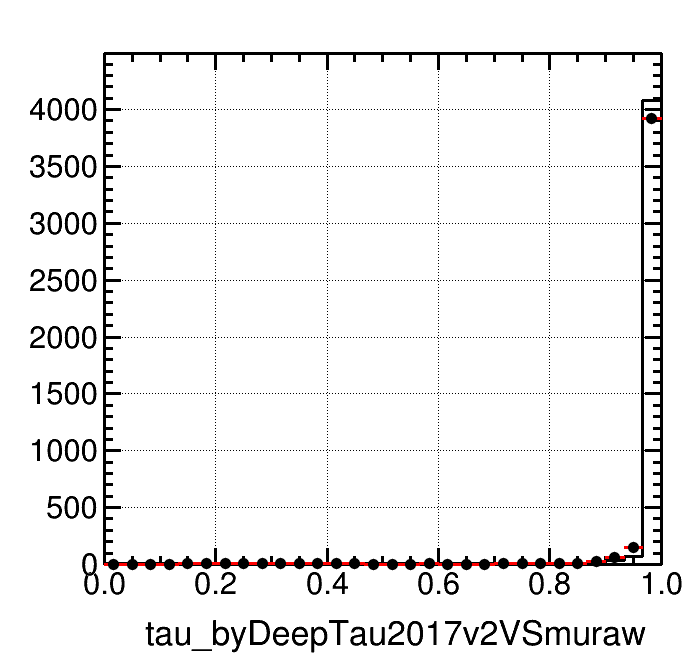

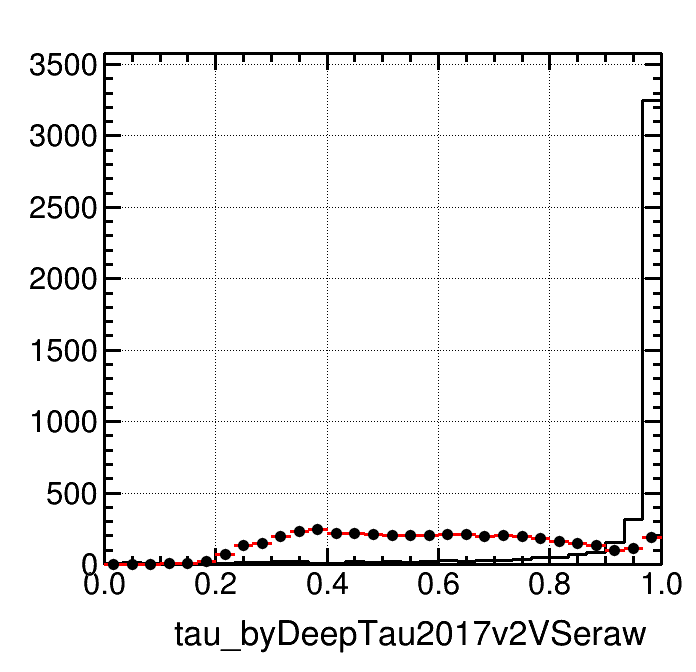

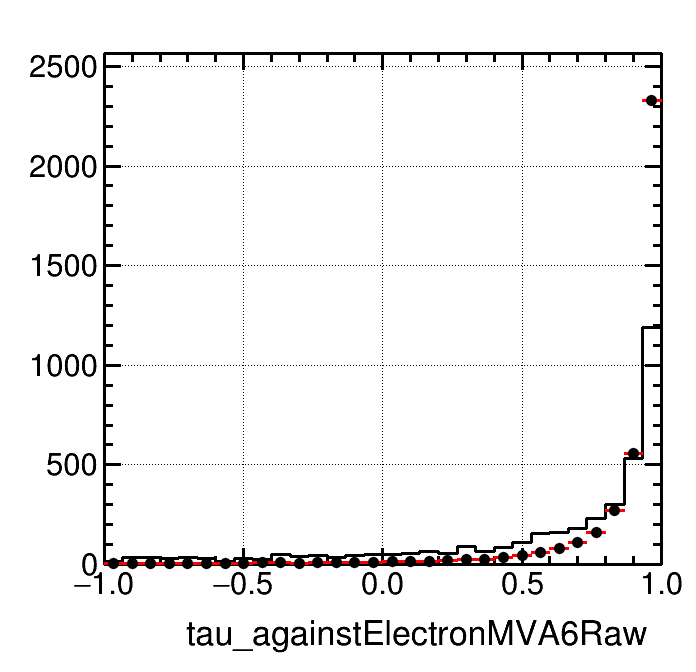

In [22]:
all_vars = [g.GetName() for g in tau_tree.GetListOfBranches() if g.GetName().startswith('tau')]
keeper = []
for var in all_vars:
    vals = tau_tree.AsMatrix(columns=[var]).flatten()
    vals = vals[vals>-10] # remove default values
    vals = vals[vals<np.percentile(vals, 99.99)] # remove outliers
    if not vals.any():
        continue
    cv = ROOT.TCanvas()
    h_s = ROOT.TH1F(f'h_{var}_s', '', 30, math.floor(np.min(vals)), math.ceil(np.max(vals)))
    tau_tree.Project(h_s.GetName(), var, base_selection)
    h_b = ROOT.TH1F(f'h_{var}_b', '', 30, math.floor(np.min(vals)), math.ceil(np.max(vals)))
    jet_tree.Project(h_b.GetName(), var, base_selection)
    n_b = h_b.Integral()
    if n_b <=0.:
        continue
    h_b.Scale(h_s.Integral()/n_b)
    h_s.GetXaxis().SetTitle(var)
    h_s.Draw()
    h_s.GetYaxis().SetRangeUser(0., 1.1*max(h_s.GetMaximum(), h_b.GetMaximum()))
    h_b.SetLineColor(2)
    h_b.Draw("same")
    cv.Draw()
    keeper.append((cv, h_s, h_b))

A useful tool to compare the discrimination of different variables that can distinguish taus and jets are so-called ROCs (receiver operating curves) that show the background efficiency vs the signal efficiency. Well-performing discriminators are very off-diagonal.

To construct a ROC, we make use of ROOT histograms for a pre-partioning of the data. While not strictly needed, it can be useful to restrict the values in the histograms to be between 0 and 1, so we transform the variables via
`x -> 1/(1+x)` (since x is positive).

In [23]:
signal = ROOT.TH1F('signal', '', 1000, 0., 1.0001)
background = ROOT.TH1F('background', '', 1000, 0., 1.0001)

tau_tree.Project('signal', '1./(1.+tau_chargedIsoPtSum)', base_selection)
jet_tree.Project('background', '1./(1.+tau_chargedIsoPtSum)', base_selection)

43847

The imported functions create a TGraph from the signal and background histograms and subsequently plot the ROC. As can be seen below, the plotting can handle multiple ROCs.

In [24]:
roc = hists_to_roc(signal, background)
roc.title = 'charged'

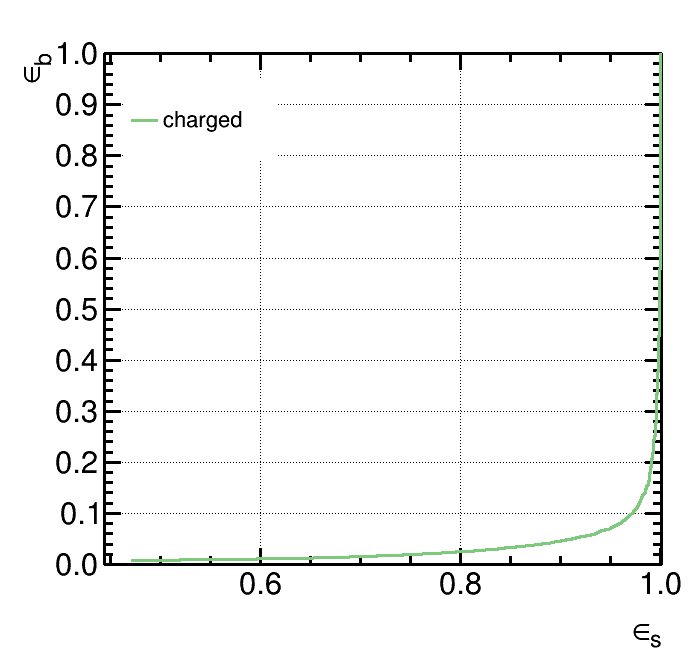

In [25]:
_, canvas = make_roc_plot([roc])
canvas.Draw()


Now that we've understood how to draw a ROC curve for a single variable, let's try to compare the performance of different tau discriminators against jets.

*Which of the discriminants performs best? Are there any drawbacks of the BDT-based or of the DeepTau discrimants?*

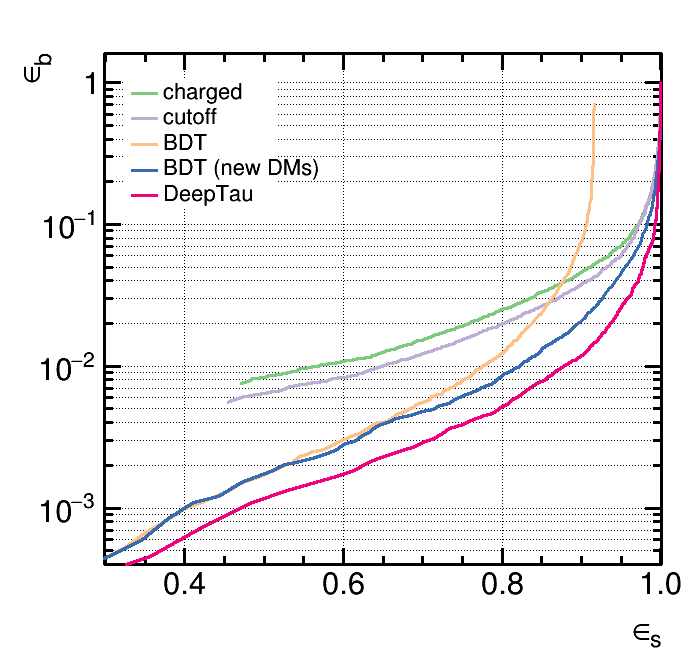

In [26]:
discriminators = {
    'tau_chargedIsoPtSum':'charged', 
    # cutoff-based tau isolation, used in run 1, e.g. in TAU-14-001 and HIG-13-004
    'tau_byCombinedIsolationDeltaBetaCorrRaw3Hits':'cutoff', 
    # BDT-based tau ID, started in TAU-14-001 and refined in TAU-16-003
    'tau_byIsolationMVArun2v1DBoldDMwLTraw':'BDT', 
    # BDT-based tau ID, started in TAU-14-001 and refined in TAU-16-003
    'tau_byIsolationMVArun2v1DBnewDMwLTraw':'BDT (new DMs)', 
    # New DNN-based ID
    'tau_byDeepTau2017v2VSjetraw':'DeepTau'
}
rocs = []
for disc, title in discriminators.items():
    s_name = 'signal'+disc
    b_name = 'background'+disc
    signal = ROOT.TH1F(s_name, '', 1000, 0., 1.0001)
    background = ROOT.TH1F(b_name, '', 1000, 0., 1.0001)
    # The BDT values lie in the range [-1, 1] so we transform x -> 1./(2+x)
    # to make sure outputs lie in the range [0, 1]
    tau_tree.Project(s_name, f'1./(2.+{disc})', base_selection)
    jet_tree.Project(b_name, f'1./(2.+{disc})', base_selection)
    roc = hists_to_roc(signal, background)
    roc.title = title
    rocs.append(roc)
_, m_canvas = make_roc_plot(rocs, xmin=0.3, ymin=0.0001, ymax=0., logy=True)
m_canvas.Draw()
    

Finally, tau identification is not only about discriminating against jets but also against electrons and muons.

* Which observables might help to distinguish taus from electrons or muons?
* Can you try to create similar ROCs as above but for the discrimination of taus against electrons or muons?

Hints:
* Use the trees created in the following cells that contain taus either coming from true muons (Z->mumu) or true electrons (Z->ee)
* As before, there are different discriminators: tau_againstElectronMVA6Raw, tau_byDeepTau2017v2VSeraw, tau_byDeepTau2017v2VSmuraw

In [27]:
muo_sample = f'{base_dir}/zmm_10_6_14.root'
ele_sample = f'{base_dir}/zee_10_6_14.root'
muo_file = ROOT.TFile.Open(muo_sample)
muo_tree = muo_file.Get('per_tau')
ele_file = ROOT.TFile.Open(ele_sample)
ele_tree = ele_file.Get('per_tau')


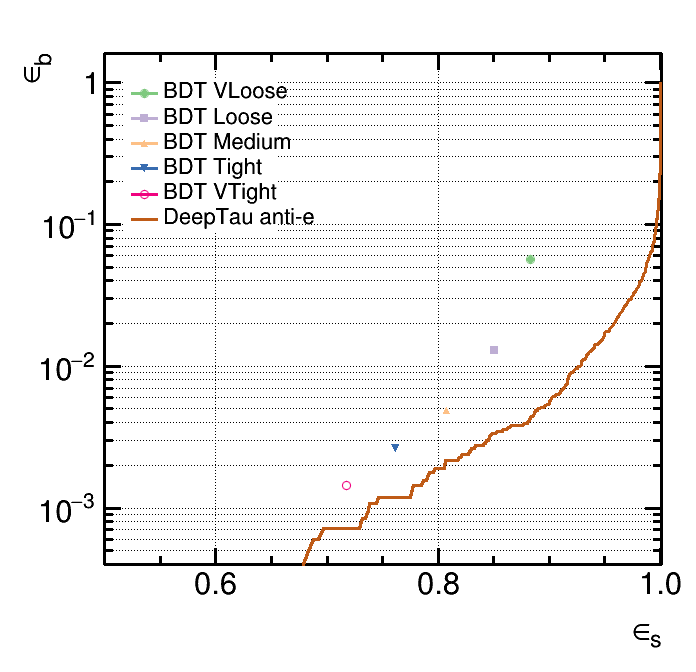

In [59]:
discriminators = {
    # BDT-based tau ID, started in TAU-14-001 and refined in TAU-16-003
#     '(tau_againstElectronMVA6Raw + 98.*(tau_againstElectronMVA6Raw<-1))':'BDT raw', 
    '(tau_againstElectronVLooseMVA6)':'BDT VLoose',
    '(tau_againstElectronLooseMVA6)':'BDT Loose', 
    '(tau_againstElectronMediumMVA6)':'BDT Medium', 
    '(tau_againstElectronTightMVA6)':'BDT Tight', 
    '(tau_againstElectronVTightMVA6)':'BDT VTight', 
    'tau_byDeepTau2017v2VSeraw':'DeepTau anti-e', 
    # New DNN-based ID
#     'tau_byDeepTau2017v2VSjetraw':'DeepTau anti-jet'
}
rocs = []
base_selection = 'tau_decayModeFinding && tau_pt>20. && abs(tau_eta)<2.3'
for disc, title in discriminators.items():
    s_name = 'signal'+title
    b_name = 'background'+title
    signal = ROOT.TH1F(s_name, '', 10000, 0., 1.0001)
    background = ROOT.TH1F(b_name, '', 10000, 0., 1.0001)
    # The BDT values lie in the range [-1, 1] so we transform x -> 1./(2+x)
    # to make sure outputs lie in the range [0, 1]
    draw_expr = f'1./(2.+{disc})'
    tau_tree.Project(s_name, draw_expr, base_selection)
    ele_tree.Project(b_name, draw_expr, base_selection)
    roc = hists_to_roc(signal, background)
    roc.title = title
    rocs.append(roc)
_, m_canvas = make_roc_plot(rocs, xmin=0.5, ymin=0.0001, ymax=0., logy=True)
m_canvas.Draw()

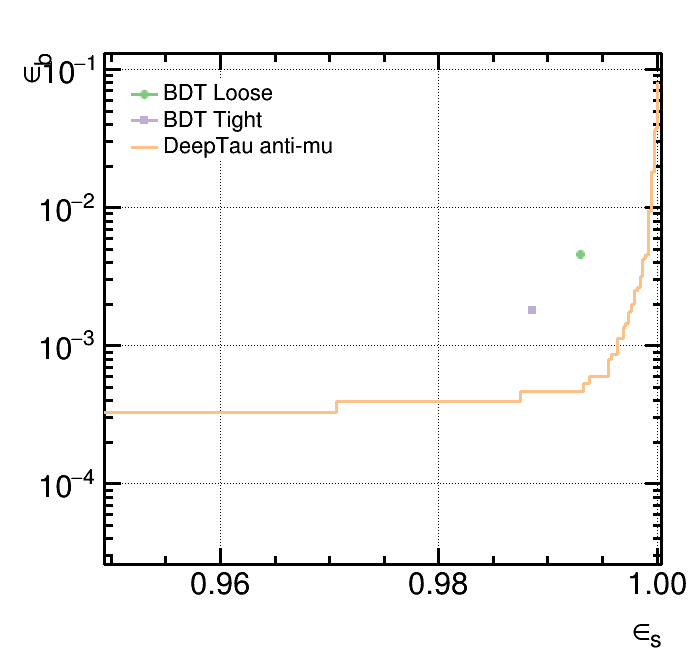

In [51]:
discriminators = {
    # BDT-based tau ID, started in TAU-14-001 and refined in TAU-16-003
    '(tau_againstMuonLoose3)':'BDT Loose', 
    '(tau_againstMuonTight3)':'BDT Tight', 
    # BDT-based tau ID, started in TAU-14-001 and refined in TAU-16-003
    'tau_byDeepTau2017v2VSmuraw':'DeepTau anti-mu', 
    # New DNN-based ID
#     'tau_byDeepTau2017v2VSjetraw':'DeepTau anti-jet'
}
rocs = []
base_selection = 'tau_decayModeFinding && tau_pt>20. && abs(tau_eta)<2.3'
for disc, title in discriminators.items():
    s_name = 'signal'+title
    b_name = 'background'+title
    signal = ROOT.TH1F(s_name, '', 10000, 0., 1.0001)
    background = ROOT.TH1F(b_name, '', 10000, 0., 1.0001)
    # The BDT values lie in the range [-1, 1] so we transform x -> 1./(2+x)
    # to make sure outputs lie in the range [0, 1]
    draw_expr = f'1./(2.+{disc})'
    tau_tree.Project(s_name, draw_expr, base_selection)
    muo_tree.Project(b_name, draw_expr, base_selection)
    roc = hists_to_roc(signal, background)
    roc.title = title
    rocs.append(roc)
_, m_canvas = make_roc_plot(rocs, xmin=0.95, ymin=0.0001, ymax=0., logy=True)
m_canvas.Draw()

Congratulations if you made it this far! It would be great if you could share with the facilitators that you finished the exercises and ideally also your final jupyter notebooks, either by email cmsdas-cern-facilitators-tau@SPAMDELETETHIScern.ch or by contacting us directly, e.g. via discord. The final notebooks can be shared in the format you prefer, e.g. by putting them into a github repository, exporting the notebook as html/pdf/..., or by other means. 

Please also fill the central feedback form on this exercise: https://docs.google.com/forms/d/e/1FAIpQLSeBKcR2PZeJnjA2uDFCVbQXWjIRBOa2YuU4B4X50SY6DHPU2w/viewform

Do not hesitate to contact us via discord or the email above if you have any additional questions or suggestions - this is a brand new exercise for the virtual CMSDAS, and we will try to improve it for future usage.